**Run the following two cells before you begin.**

In [6]:
%autosave 10

Autosaving every 10 seconds


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib inline

**First, import the cleaned data set. Then, select the features from the DataFrame of the case study data.**
    
These features should be: `'LIMIT_BAL'`, `'EDUCATION'`, `'MARRIAGE'`, `'AGE'`, `'PAY_1'`, `'BILL_AMT1'`, `'BILL_AMT2'`, `'BILL_AMT3'`, `'BILL_AMT4'`, `'BILL_AMT5'`, `'BILL_AMT6'`, `'PAY_AMT1'`, `'PAY_AMT2'`, `'PAY_AMT3'`, `'PAY_AMT4'`, `'PAY_AMT5'`, AND `'PAY_AMT6'`.

In [8]:
# Import data set
df=pd.read_csv('cleaned_data.csv')

In [9]:
# Create features list
features=['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5','PAY_AMT6']

_____________________________________________________
**Next, make a 80:20 train/test split using a random seed of 24.**

In [10]:
X_train,X_test,y_train,y_test= train_test_split(df[features],df['default payment next month'],test_size=0.2,random_state=24,stratify=df['default payment next month'])

_____________________________________________________
**Then, instantiate the `MinMaxScaler` to scale the data.**

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

_____________________________________________________
**Next, instantiate a logistic regression model with the `saga` solver, L1 penalty, and set `max_iter` to 1,000 as we want the solver to have enough iterations to find a good solution.**

In [12]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(solver='saga',penalty='l1',max_iter=1000)

_____________________________________________________
**Next, import the `Pipeline` class and create a `Pipeline` with the scaler and the logistic regression model, using the names `'scaler'` and `'model'` for the steps, respectively.**

In [13]:
from sklearn.pipeline import Pipeline
steps=[('Scaling',scaler),('Model',model)]
pipeline=Pipeline(steps)

_____________________________________________________
**Now, use the `get_params` method to view the parameters from each stage of the pipeline.**

In [14]:
# Use `get_params`
pipeline.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('Scaling', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('Model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)>

**Use the `set_params` method to change the the `model__C` parameter to 2.**

In [15]:
# View what `model__C` is set to currently
pipeline.get_params()['Model__C']

1.0

In [16]:
# Change `model__C` to 2
pipeline.set_params(Model__C=2)

Pipeline(memory=None,
         steps=[('Scaling', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('Model',
                 LogisticRegression(C=2, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

_____________________________________________________
**Then, create a smaller range of C values to test with cross-validation, as these models will take longer to train and test with more data than our previous activities.**

**Use C_vals = [$10^2$, $10$, $1$, $10^{-1}$, $10^{-2}$, $10^{-3}$].**


<details>
    <summary>Hint:</summary>
    Recall that exponents in Python use the ** operator.
</details>

In [17]:
C_vals=[10**2,10,1,10**(-1),10**(-2),10**(-3)]
C_vals

[100, 10, 1, 0.1, 0.01, 0.001]

Now, define `k_folds` using `StratifiedKFold`. The number of folds should be 4. Set the random state to 1.

In [23]:
from sklearn.model_selection import StratifiedKFold
k_folds=StratifiedKFold(n_splits=4,random_state=1,shuffle=True)


_____________________________________________________
**Next, make a new version of the `cross_val_C_search` function, called `cross_val_C_search_pipe`. Instead of the model argument, this function will take a pipeline argument. The changes inside the function will be to set the `C` value using `set_params(model__C = <value you want to test>)` on the pipeline, replacing the model with the pipeline for the fit and `predict_proba` methods, and accessing the `C` value using `pc` for the printed status update.**

In [53]:
'''def cross_val_C_search_pipe(pipe):
    score=[]
    score_train=[]
    for c in C_vals:
        ('The Value of C is',pipe.get_params()['Model__C'])
        pipe.set_params(Model__C=c)
        pipe.fit(X_train,y_train)
        a=(pipe.predict_proba(X_test))
        b=pipe.predict_proba(X_train)
        score.append(roc_auc_score(y_test,a[:,1]))
        score_train.append(roc_auc_score(y_train,b[:,1]))
    return score,score_train'''
def cross_val_C_search_pipe(k_folds, C_vals, model, X, Y):
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
   
    for c_val_counter in range(len(C_vals)):
        model.set_params(Model__C= C_vals[c_val_counter]) 
        fold_counter = 0
        for train_index, test_index in k_folds.split(X, Y):
            X_cv_train, X_cv_test = X.iloc[train_index], X.iloc[test_index]
            y_cv_train, y_cv_test = Y.iloc[train_index], Y.iloc[test_index]
            model.fit(X_cv_train, y_cv_train)
            y_cv_train_predict_proba = model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] =roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])
            y_cv_test_predict_proba = model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])
            
            fold_counter += 1
        #print('Done with C = {}'.format(lr_syn.C))
    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc
    
        

_____________________________________________________
**Now, run this function as in the previous activity, but using the new range of `C` values, the pipeline you created, and the features and response variable from the training split of the case study data.**

    You may see warnings here, or in later steps, about the non-convergence of the solver; you could experiment with the `tol` or `max_iter`` options to try and achieve convergence, although the results you obtain with `max_iter = 1000` are likely to be sufficient.

In [55]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc=cross_val_C_search_pipe(k_folds,C_vals,pipeline,df[features],df['default payment next month'])


_____________________________________________________
**Plot the average training and testing ROC AUC across folds, for each `np.log(C_vals)` value.**

[[0.7205082  0.72033305 0.71845811 0.71491326 0.71454    0.5       ]
 [0.71554506 0.71532146 0.71326745 0.70940671 0.70981364 0.5       ]
 [0.72339122 0.72321939 0.72158129 0.71677685 0.71736402 0.5       ]
 [0.71696255 0.71677084 0.71479519 0.71124998 0.71160608 0.5       ]]
6


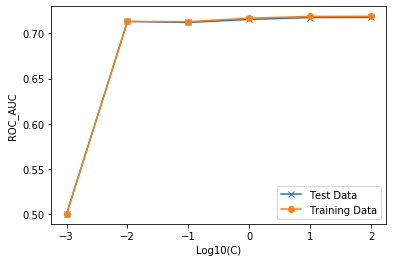

In [58]:
roc_auc_train_avg=cv_train_roc_auc.mean(axis=0)
roc_auc_test_avg=cv_test_roc_auc.mean(axis=0)
print(cv_train_roc_auc)
print(len(roc_auc_test_avg))
plt.plot(np.log10(C_vals),roc_auc_test_avg,'x-',label='Test Data')
plt.plot(np.log10(C_vals),roc_auc_train_avg,'o-',label='Training Data')
plt.legend()
plt.xlabel('Log10(C)')
plt.ylabel('ROC_AUC')
plt.show()

_____________________________________________________
**Up next, create interaction features for the case study data using scikit-learn's `PolynomialFeatures`. You should use 2 as the degree of polynomial features. Confirm that the number of new features makes sense.**

In [61]:
from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures(2)
X=df[features]
X=poly.fit_transform(X)
X=pd.DataFrame(X)

_____________________________________________________
**Finally, repeat the cross-validation procedure and observe the model performance now.**

In [62]:
# Using the new features, make a 80:20 train/test split using a random seed of 24.**
X_train,X_test,y_train,y_test= train_test_split(X,df['default payment next month'],test_size=0.2,random_state=24,stratify=df['default payment next month'])

In [63]:
# Call the cross_val_C_search_pipe() function using the new training data.
# All other parameters should remain the same.
# Note that this training may take a few minutes due to the larger number of features.
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc=cross_val_C_search_pipe(k_folds,C_vals,pipeline,X,df['default payment next month'])

C:\Users\agoel\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\agoel\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\agoel\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\agoel\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\agoel\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

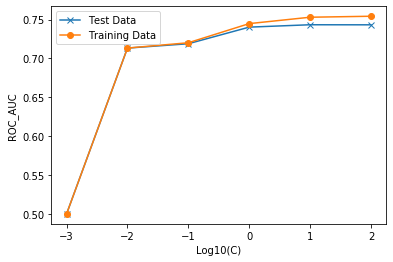

In [66]:
# Plot the average training and testing ROC AUC across folds, for each C value.
roc_auc_train_avg=cv_train_roc_auc.mean(axis=0)
roc_auc_test_avg=cv_test_roc_auc.mean(axis=0)
plt.plot(np.log10(C_vals),roc_auc_test_avg,'x-',label='Test Data')
plt.plot(np.log10(C_vals),roc_auc_train_avg,'o-',label='Training Data')
plt.legend()
plt.xlabel('Log10(C)')
plt.ylabel('ROC_AUC')
plt.show()

**Take a look at the above graph. Does the average cross-validation testing performance improve with the interaction features? Is regularization useful?**